<a href="https://colab.research.google.com/github/cuducquang/Deep-Learning/blob/main/version6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 - Setup Frameworks and Libraries

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.2 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import keras_tuner as kt
import tensorflow as tf

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense, Dropout,
    BatchNormalization, Activation,
    GlobalAveragePooling2D, GlobalMaxPooling2D,
    Concatenate, Add
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

## 2 - EDA

In [ ]:
data = np.load('dataset_dev_3000.npz')
X = data['X']   # Input images
y = data['y']   # Multi-target labels

# 2. Decompose Targets for Analysis
# y[:, 0]: Target A (Classification 0-9)
# y[:, 1]: Target B (Classification 0-31)
# y[:, 2]: Target C (Regression 0-1)
y_target_A = y[:, 0].astype(int)
y_target_B = y[:, 1].astype(int)
y_target_C = y[:, 2]

print("Data Loaded Successfully")
print(f"X Shape: {X.shape} | Type: {X.dtype}")
print(f"y Shape: {y.shape} | Type: {y.dtype}")
print("-" * 30)
print(f"Target A (Class 10): Unique values: {np.unique(y_target_A)}")
print(f"Target B (Class 32): Unique values count: {len(np.unique(y_target_B))}")
print(f"Target C (Regress):  Range [{y_target_C.min():.4f}, {y_target_C.max():.4f}]")

Data Loaded Successfully
X Shape: (3000, 32, 32) | Type: float32
y Shape: (3000, 3) | Type: float32
------------------------------
Target A (Class 10): Unique values: [0 1 2 3 4 5 6 7 8 9]
Target B (Class 32): Unique values count: 32
Target C (Regress):  Range [0.0003, 0.9996]


In [ ]:
# Check Pixel Intensity Statistics
print(" Pixel Value Statistics:")
print(f"Min : {X.min()}")
print(f"Max : {X.max()}")
print(f"Mean: {X.mean():.2f}")
print(f"Std : {X.std():.2f}")

# Check for Channel Dimension
if X.ndim == 3:
    print("Insight: Images are Rank-3 (N, H, W). Need to expand dims to (N, H, W, 1) for CNN.")
else:
    print("Images already have channel dimension.")

 Pixel Value Statistics:
Min : 5.5413776863133535e-05
Max : 6.8485941886901855
Mean: 0.81
Std : 0.74
Insight: Images are Rank-3 (N, H, W). Need to expand dims to (N, H, W, 1) for CNN.


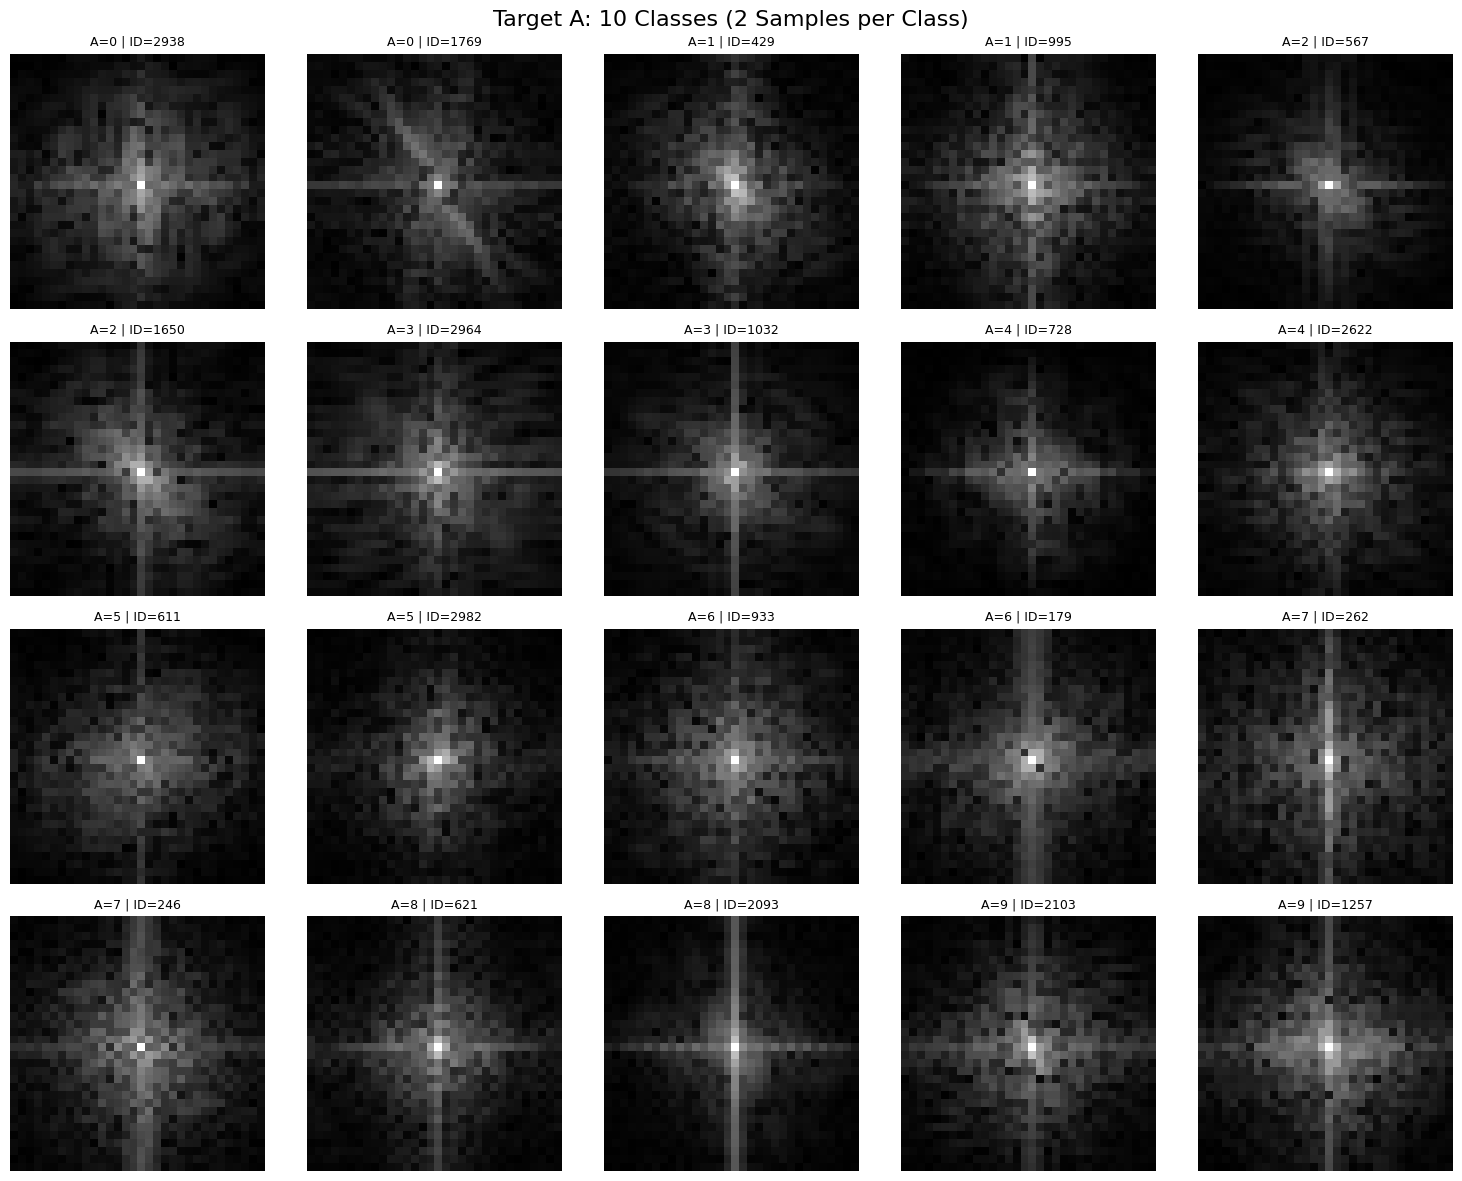

In [ ]:
# Visualize random samples with their 3 labels
# -------- FIGURE 1: Target A --------
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.flatten()

plot_idx = 0
for cls in range(10):
    cls_indices = np.where(y_target_A == cls)[0]
    chosen = np.random.choice(cls_indices, 2, replace=False)

    for idx in chosen:
        ax = axes[plot_idx]
        ax.imshow(X[idx], cmap='gray')
        ax.set_title(f"A={cls} | ID={idx}", fontsize=9)
        ax.axis('off')
        plot_idx += 1

fig.suptitle("Target A: 10 Classes (2 Samples per Class)", fontsize=16)
plt.tight_layout()
plt.show()

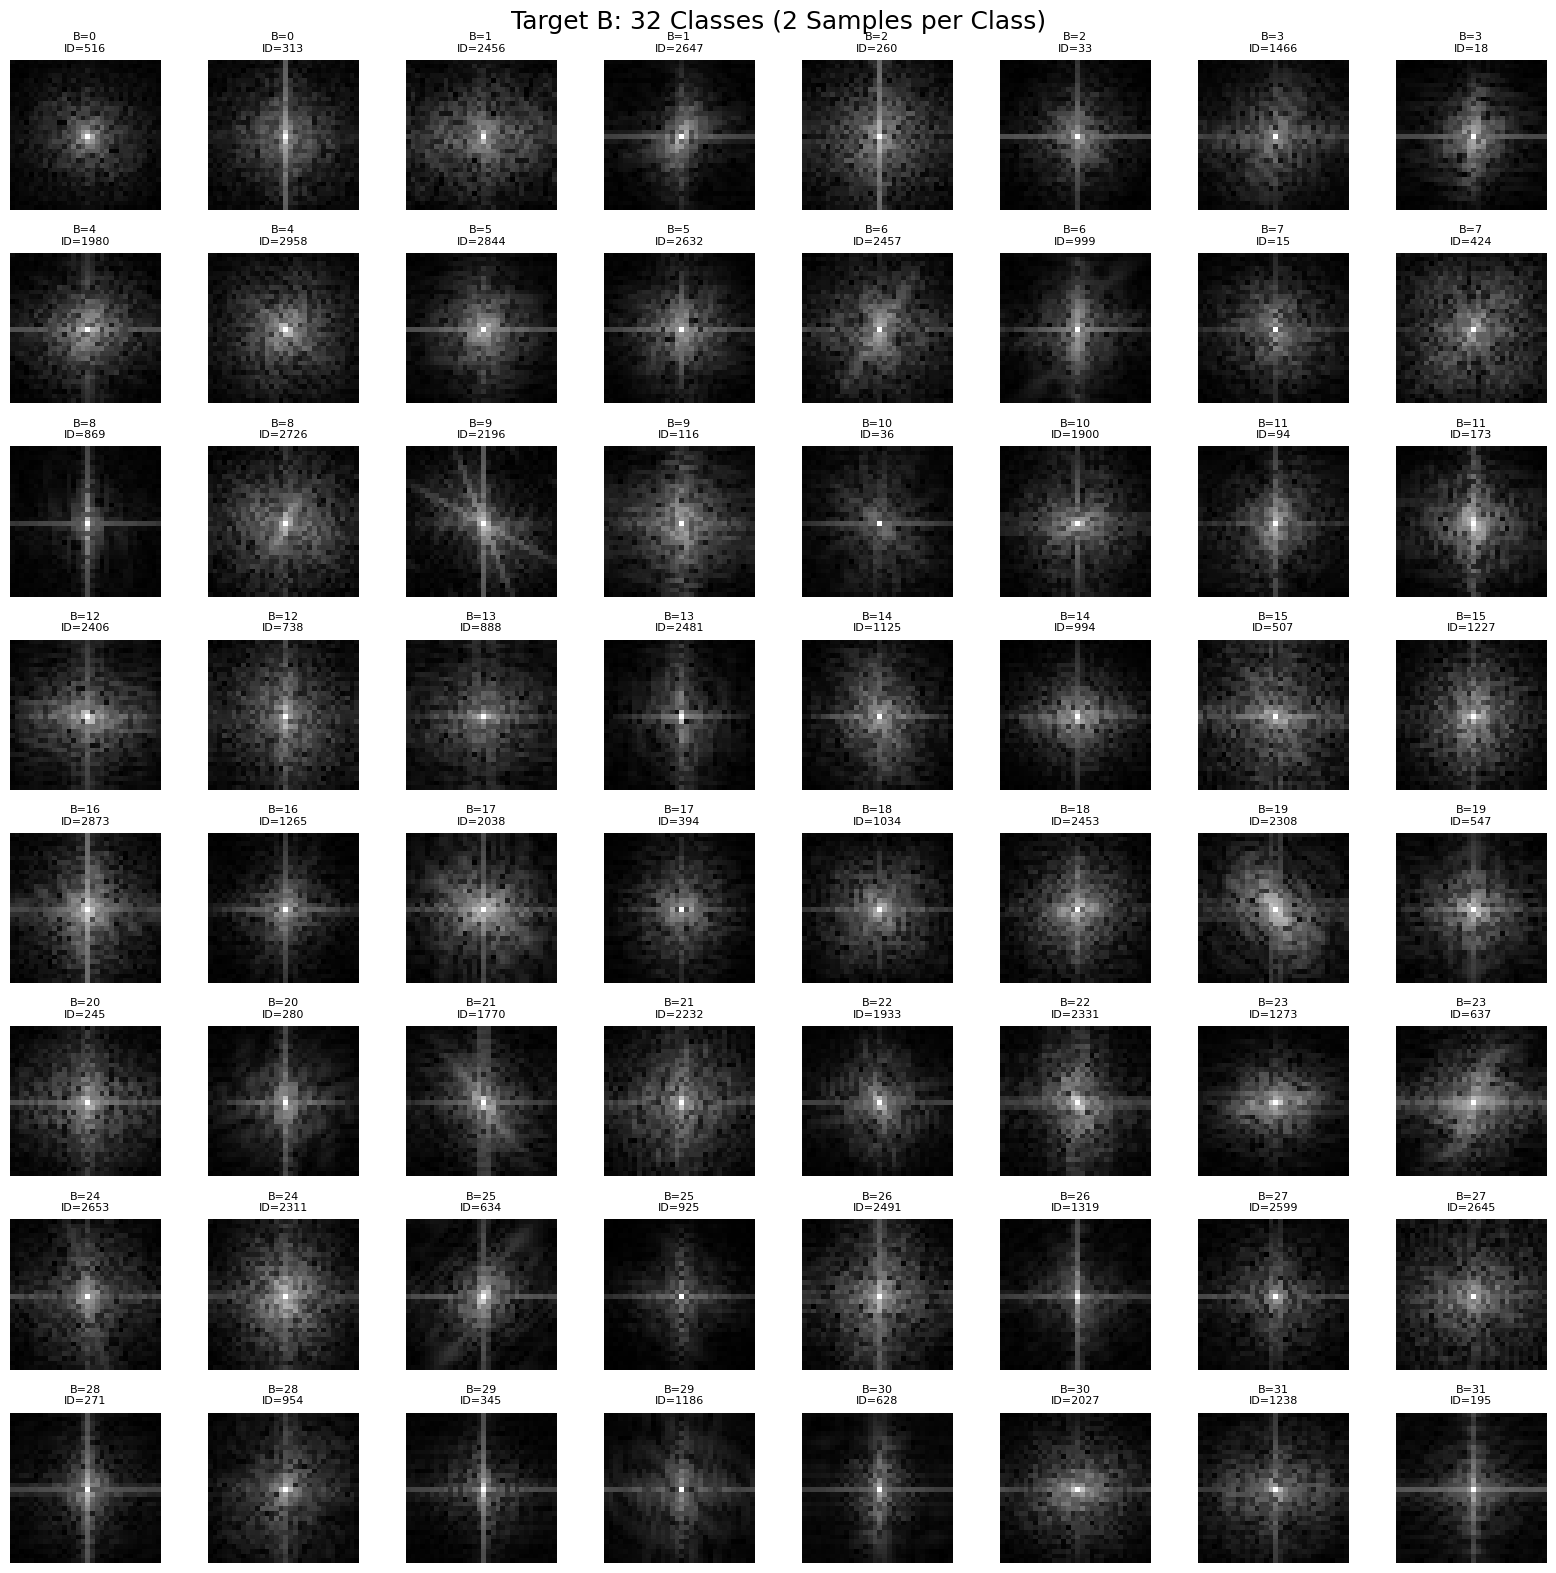

In [ ]:
# -------- FIGURE 2: Target B --------
fig, axes = plt.subplots(8, 8, figsize=(16, 16))
axes = axes.flatten()

plot_idx = 0
for cls in range(32):
    cls_indices = np.where(y_target_B == cls)[0]
    chosen = np.random.choice(cls_indices, 2, replace=False)

    for idx in chosen:
        ax = axes[plot_idx]
        ax.imshow(X[idx], cmap='gray')
        ax.set_title(f"B={cls}\nID={idx}", fontsize=8)
        ax.axis('off')
        plot_idx += 1

fig.suptitle("Target B: 32 Classes (2 Samples per Class)", fontsize=18)
plt.tight_layout()
plt.show()

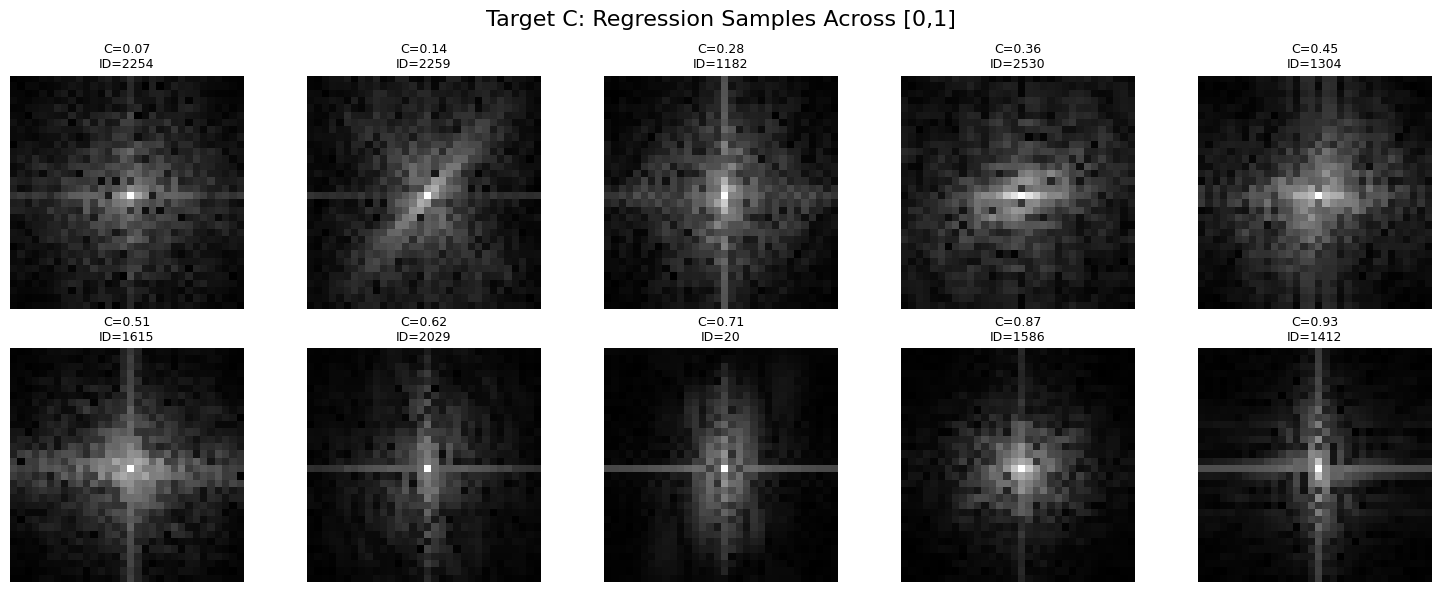

In [ ]:
# -------- FIGURE 3: Target C --------
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

bins = np.linspace(0, 1, 11)

selected_indices = []
for i in range(10):
    bin_indices = np.where(
        (y_target_C >= bins[i]) & (y_target_C < bins[i+1])
    )[0]
    if len(bin_indices) > 0:
        selected_indices.append(np.random.choice(bin_indices))

for ax, idx in zip(axes, selected_indices):
    ax.imshow(X[idx], cmap='gray')
    ax.set_title(f"C={y_target_C[idx]:.2f}\nID={idx}", fontsize=9)
    ax.axis('off')

fig.suptitle("Target C: Regression Samples Across [0,1]", fontsize=16)
plt.tight_layout()
plt.show()

Target A Balance Check: {np.int64(0): np.int64(290), np.int64(1): np.int64(304), np.int64(2): np.int64(311), np.int64(3): np.int64(305), np.int64(4): np.int64(306), np.int64(5): np.int64(294), np.int64(6): np.int64(290), np.int64(7): np.int64(291), np.int64(8): np.int64(310), np.int64(9): np.int64(299)}


/tmp/ipython-input-1890465473.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_target_A, palette='viridis')


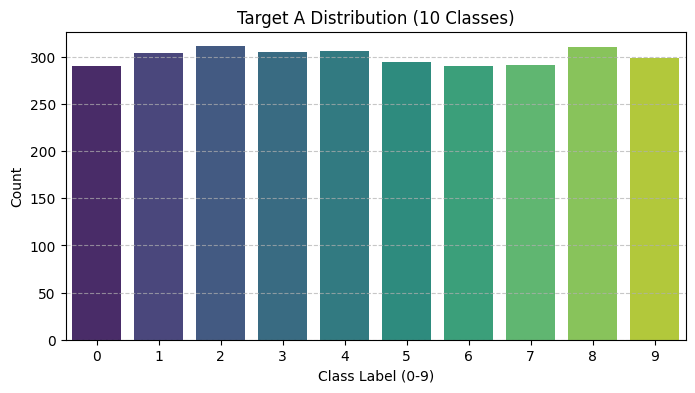

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(x=y_target_A, palette='viridis')
plt.title("Target A Distribution (10 Classes)")
plt.xlabel("Class Label (0-9)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Check exact counts
unique, counts = np.unique(y_target_A, return_counts=True)
print("Target A Balance Check:", dict(zip(unique, counts)))
plt.show()

/tmp/ipython-input-1059615394.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_target_B, palette='magma')


Target B - Min samples per class: 75
Target B - Max samples per class: 113


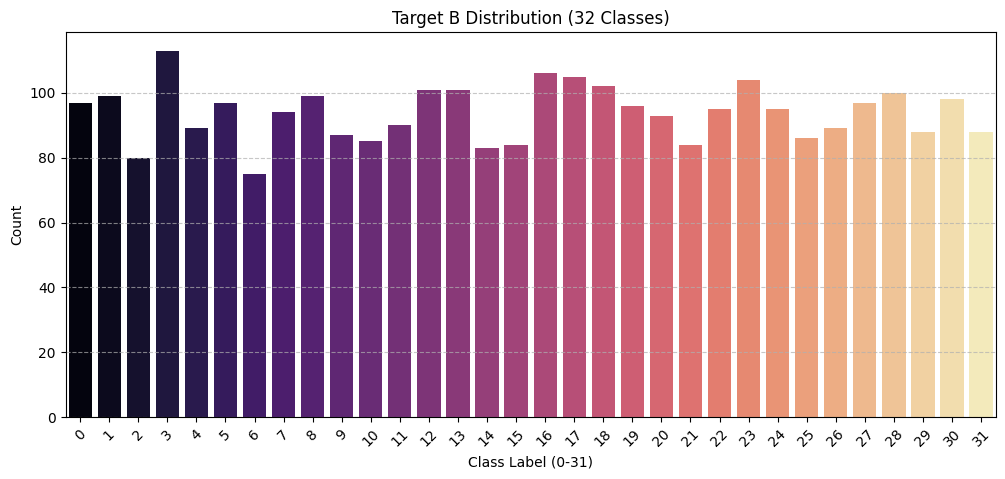

In [ ]:
plt.figure(figsize=(12, 5))
sns.countplot(x=y_target_B, palette='magma')
plt.title("Target B Distribution (32 Classes)")
plt.xlabel("Class Label (0-31)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Statistics for Target B
unique_b, counts_b = np.unique(y_target_B, return_counts=True)
print(f"Target B - Min samples per class: {counts_b.min()}")
print(f"Target B - Max samples per class: {counts_b.max()}")
plt.show()

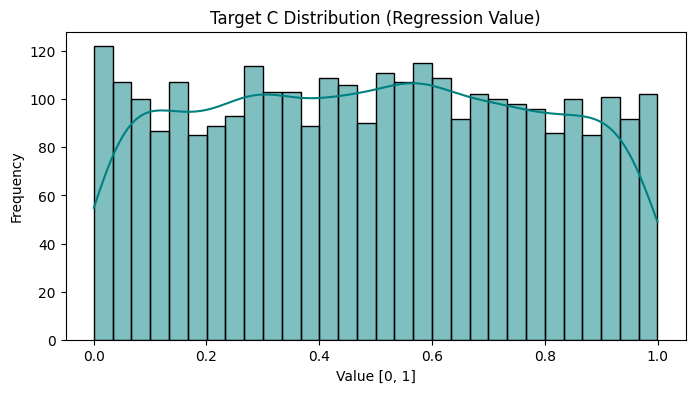

In [ ]:
plt.figure(figsize=(8, 4))
sns.histplot(y_target_C, kde=True, bins=30, color='teal')
plt.title("Target C Distribution (Regression Value)")
plt.xlabel("Value [0, 1]")
plt.ylabel("Frequency")
plt.show()

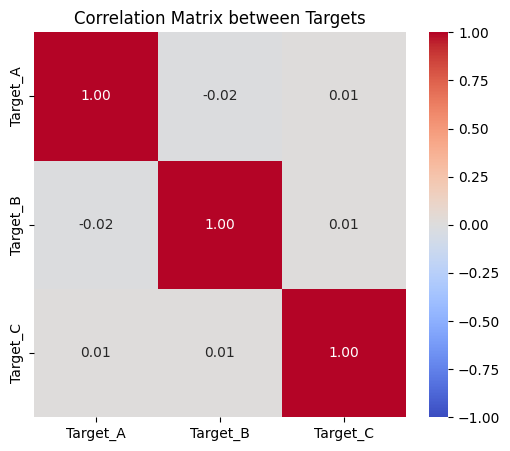

In [ ]:
# Create a DataFrame for correlation checking
df_targets = pd.DataFrame({
    'Target_A': y_target_A,
    'Target_B': y_target_B,
    'Target_C': y_target_C
})

# Compute Correlation Matrix
corr_matrix = df_targets.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix between Targets")
plt.show()

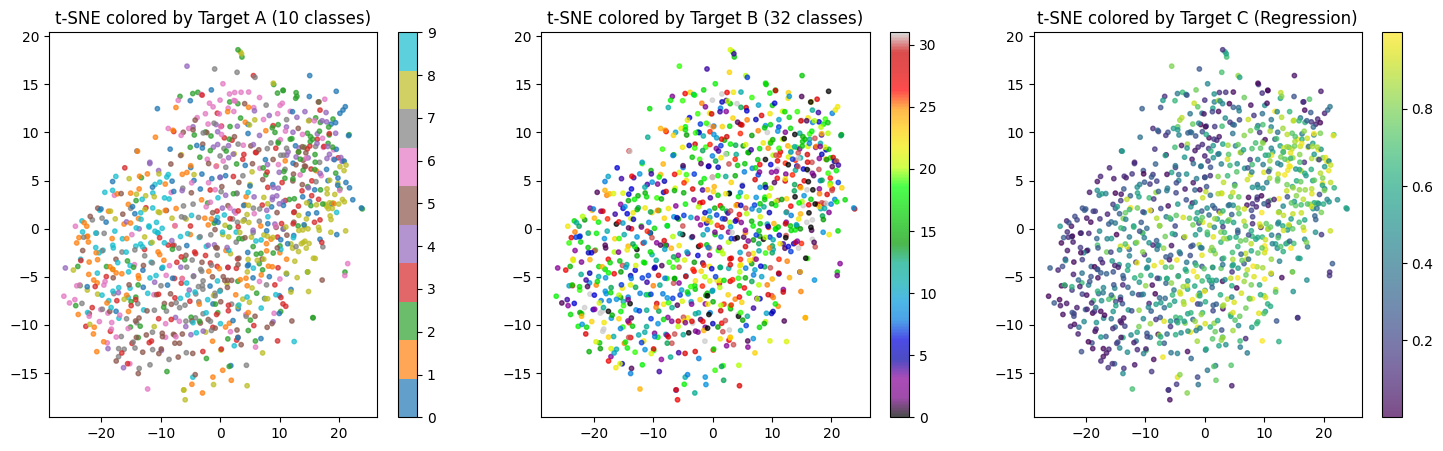

In [ ]:
# Subsample for speed (1000 samples)
idx_subset = np.random.choice(len(X), 1000, replace=False)
X_tsne_input = X[idx_subset].reshape(1000, -1)
y_tsne_A = y_target_A[idx_subset]
y_tsne_B = y_target_B[idx_subset]
y_tsne_C = y_target_C[idx_subset]

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_embedded = tsne.fit_transform(X_tsne_input)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot colored by Target A
scatter1 = axes[0].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_A, cmap='tab10', s=10, alpha=0.7)
axes[0].set_title("t-SNE colored by Target A (10 classes)")
plt.colorbar(scatter1, ax=axes[0])

# Plot colored by Target B
scatter2 = axes[1].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_B, cmap='nipy_spectral', s=10, alpha=0.7)
axes[1].set_title("t-SNE colored by Target B (32 classes)")
plt.colorbar(scatter2, ax=axes[1])

# Plot colored by Target C
scatter3 = axes[2].scatter(X_embedded[:,0], X_embedded[:,1], c=y_tsne_C, cmap='viridis', s=10, alpha=0.7)
axes[2].set_title("t-SNE colored by Target C (Regression)")
plt.colorbar(scatter3, ax=axes[2])

plt.show()

## 3 - Data Preprocessing

In [ ]:
# 1. Normalize & Reshape
#  max value = 6.8485941886901855
MAX_PIXEL_VALUE = X.max()
X_norm = X.astype('float32') / MAX_PIXEL_VALUE
X_norm = np.expand_dims(X_norm, axis=-1) # (3000, 32, 32, 1)

# 2. Decompose Targets
y_A_raw = y[:, 0].astype(int)   # Class 0-9
y_B_raw = y[:, 1].astype(int)   # Class 0-31
y_C_raw = y[:, 2].astype(float) # Regression

# 3. Split Data (Train 70% - Val 15% - Test 15%)
# Split 1: Train vs Temp
X_train, X_temp, yA_train, yA_temp, yB_train, yB_temp, yC_train, yC_temp = train_test_split(
    X_norm, y_A_raw, y_B_raw, y_C_raw,
    test_size=0.3, random_state=42, stratify=y_B_raw
)

# Split 2: Val vs Test
X_val, X_test, yA_val, yA_test, yB_val, yB_test, yC_val, yC_test = train_test_split(
    X_temp, yA_temp, yB_temp, yC_temp,
    test_size=0.5, random_state=42, stratify=yB_temp
)

# 4. Target Encoding
# Target C: Reshape to (N, 1) for Regression
yC_train_reg = yC_train.reshape(-1, 1)
yC_val_reg   = yC_val.reshape(-1, 1)
yC_test_reg  = yC_test.reshape(-1, 1)

print(f"Train Set: {X_train.shape}")
print(f"Val Set:   {X_val.shape}")
print(f"Test Set:  {X_test.shape}")
print(f"Target A (Train) shape: {yA_train.shape} (Sparse/Integer)")

Train Set: (2100, 32, 32, 1)
Val Set:   (450, 32, 32, 1)
Test Set:  (450, 32, 32, 1)
Target A (Train) shape: (2100,) (Sparse/Integer)


In [ ]:
# 1. SETUP DATA AUGMENTATION
# A. Train Datagen
train_datagen = ImageDataGenerator(
    # rotation_range=8,
    # width_shift_range=0.05,
    # height_shift_range=0.05,
    # zoom_range=0.05,
    # fill_mode='nearest'
)

# B. Val/Test Datagen
val_datagen = ImageDataGenerator()

# 2. CUSTOM GENERATOR WRAPPER
def multi_output_data_generator(X, yA, yB, yC, batch_size, datagen):
    indices = np.arange(len(X))
    gen_X = datagen.flow(X, indices, batch_size=batch_size, shuffle=True)

    while True:
        X_batch, idx_batch = next(gen_X)
        yA_batch = yA[idx_batch]
        yB_batch = yB[idx_batch]
        yC_batch = yC[idx_batch]

        yield X_batch, {
            'output_A': yA_batch,
            'output_B': yB_batch,
            'output_C': yC_batch
        }

# 3. INSTANTIATE GENERATORS
BATCH_SIZE = 32

train_gen = multi_output_data_generator(
    X_train, yA_train, yB_train, yC_train_reg,
    batch_size=BATCH_SIZE,
    datagen=train_datagen
)

val_gen = multi_output_data_generator(
    X_val, yA_val, yB_val, yC_val_reg,
    batch_size=BATCH_SIZE,
    datagen=val_datagen
)

## 4 - Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

inputs = tf.keras.Input(shape=(32, 32, 1), name="input_image")

# -------- Shared (SHALLOW) --------
x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

shared = layers.Activation('linear', name="shared_block")(x)

# -------- Task A (10-class) --------
a = layers.Conv2D(128, 3, padding='same', activation='relu')(shared)
a = layers.BatchNormalization()(a)
a = layers.GlobalAveragePooling2D()(a)
a = layers.Dense(
    128, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
)(a)
a = layers.Dropout(0.5)(a)
output_A = layers.Dense(10, activation='softmax', name='output_A')(a)

# -------- Task B (32-class, harder) --------
b = layers.Conv2D(128, 3, padding='same', activation='relu')(shared)
b = layers.BatchNormalization()(b)
b = layers.Conv2D(128, 3, padding='same', activation='relu')(b)
b = layers.BatchNormalization()(b)
b = layers.GlobalAveragePooling2D()(b)
b = layers.Dense(
    256, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
)(b)
b = layers.Dropout(0.5)(b)
output_B = layers.Dense(32, activation='softmax', name='output_B')(b)

# -------- Task C (Regression) --------
c = layers.Conv2D(64, 3, padding='same', activation='relu')(shared)
c = layers.BatchNormalization()(c)
c = layers.GlobalAveragePooling2D()(c)
c = layers.Dense(
    64, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
)(c)
output_C = layers.Dense(1, activation='linear', name='output_C')(c)

# -------- Model --------
model = tf.keras.Model(
    inputs=inputs,
    outputs=[output_A, output_B, output_C]
)


In [ ]:
def compile_model(model, lr):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss={
            'output_A': tf.keras.losses.SparseCategoricalCrossentropy(),
            'output_B': tf.keras.losses.SparseCategoricalCrossentropy(),
            'output_C': tf.keras.losses.Huber()
        },
        loss_weights={
            'output_A': 1.0,
            'output_B': 2.0,
            'output_C': 0.3
        },
        metrics={
            'output_A': ['accuracy'],
            'output_B': ['accuracy'],
            'output_C': ['mae']
        }
    )


In [ ]:
steps_per_epoch      = len(X_train) // BATCH_SIZE
validation_steps     = len(X_val)   // BATCH_SIZE

# Freeze shared block
model.get_layer("shared_block").trainable = False

compile_model(model, lr=1e-3)

print("Starting WARM-UP training...")

history_warmup = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=20,
    verbose=1
)


Starting WARM-UP training...
Epoch 1/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step - loss: 9.2808 - output_A_accuracy: 0.1523 - output_A_loss: 2.2543 - output_B_accuracy: 0.0362 - output_B_loss: 3.4851 - output_C_loss: 0.0664 - output_C_mae: 0.2791 - val_loss: 9.8298 - val_output_A_accuracy: 0.0982 - val_output_A_loss: 2.6575 - val_output_B_accuracy: 0.0357 - val_output_B_loss: 3.5612 - val_output_C_loss: 0.0467 - val_output_C_mae: 0.2585
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 8.9258 - output_A_accuracy: 0.2879 - output_A_loss: 2.0346 - output_B_accuracy: 0.0485 - output_B_loss: 3.4248 - output_C_loss: 0.0191 - output_C_mae: 0.1536 - val_loss: 11.2921 - val_output_A_accuracy: 0.1205 - val_output_A_loss: 3.9485 - val_output_B_accuracy: 0.0402 - val_output_B_loss: 3.6458 - val_output_C_loss: 0.0545 - val_output_C_mae: 0.2725
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.6832 - output_A_accuracy: 0.2979 - output_A_loss: 1.9597 - output_B_accuracy: 0.0612 

In [ ]:
def compile_model(model, lr):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss={
            'output_A': tf.keras.losses.SparseCategoricalCrossentropy(),
            'output_B': tf.keras.losses.SparseCategoricalCrossentropy(),
            'output_C': tf.keras.losses.Huber()
        },
        loss_weights={
            'output_A': 1.0,
            'output_B': 2.0,
            'output_C': 0.3
        },
        metrics={
            'output_A': ['accuracy'],
            'output_B': ['accuracy'],
            'output_C': ['mae']
        }
    )



In [ ]:
model.get_layer("shared_block").trainable = True
compile_model(model, lr=3e-4)

In [ ]:
print("Starting FINE-TUNING...")

history_finetune = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=100,                      # total fine-tune epochs
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            min_lr=1e-5
        )
    ],
    verbose=1
)


Starting FINE-TUNING...
Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 112ms/step - loss: 1.5404 - output_A_accuracy: 0.8657 - output_A_loss: 0.4611 - output_B_accuracy: 0.8413 - output_B_loss: 0.5140 - output_C_loss: 0.0036 - output_C_mae: 0.0673 - val_loss: 13.7178 - val_output_A_accuracy: 0.2847 - val_output_A_loss: 2.2592 - val_output_B_accuracy: 0.0574 - val_output_B_loss: 5.7357 - val_output_C_loss: 0.0093 - val_output_C_mae: 0.1117 - learning_rate: 3.0000e-04
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8774 - output_A_accuracy: 0.9356 - output_A_loss: 0.3084 - output_B_accuracy: 0.9388 - output_B_loss: 0.2569 - output_C_loss: 0.0038 - output_C_mae: 0.0681 - val_loss: 13.8331 - val_output_A_accuracy: 0.3612 - val_output_A_loss: 2.2349 - val_output_B_accuracy: 0.0646 - val_output_B_loss: 5.7806 - val_output_C_loss: 0.0210 - val_output_C_mae: 0.1463 - learning_rate: 3.0000e-04
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7451 - output_A_accuracy: 0.949

In [ ]:
import matplotlib.pyplot as plt

def plot_task_losses(history):
    plt.figure(figsize=(10, 6))

    plt.plot(history['output_A_loss'], label='Train A Loss')
    plt.plot(history['val_output_A_loss'], label='Val A Loss')

    plt.plot(history['output_B_loss'], label='Train B Loss')
    plt.plot(history['val_output_B_loss'], label='Val B Loss')

    plt.plot(history['output_C_loss'], label='Train C Loss')
    plt.plot(history['val_output_C_loss'], label='Val C Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Multi-task Loss Curves')
    plt.legend()
    plt.grid(True)
    plt.show()


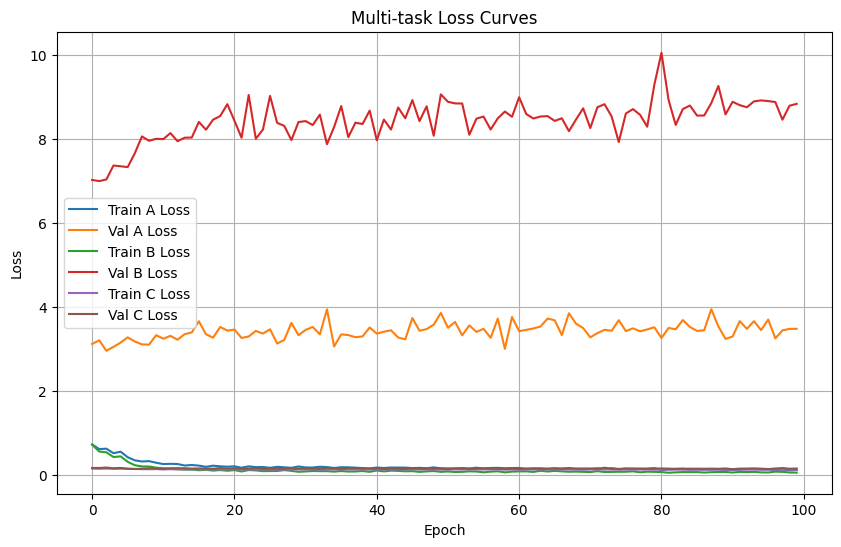

In [ ]:
plot_task_losses(history_finetune.history)


In [ ]:
def plot_all_tasks(history):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Task A
    axs[0].plot(history['output_A_accuracy'], label='Train')
    axs[0].plot(history['val_output_A_accuracy'], label='Val')
    axs[0].set_title('Task A Accuracy')
    axs[0].legend()
    axs[0].grid()

    # Task B
    axs[1].plot(history['output_B_accuracy'], label='Train')
    axs[1].plot(history['val_output_B_accuracy'], label='Val')
    axs[1].set_title('Task B Accuracy')
    axs[1].legend()
    axs[1].grid()

    # Task C
    axs[2].plot(history['output_C_mae'], label='Train')
    axs[2].plot(history['val_output_C_mae'], label='Val')
    axs[2].set_title('Task C MAE')
    axs[2].legend()
    axs[2].grid()

    plt.show()


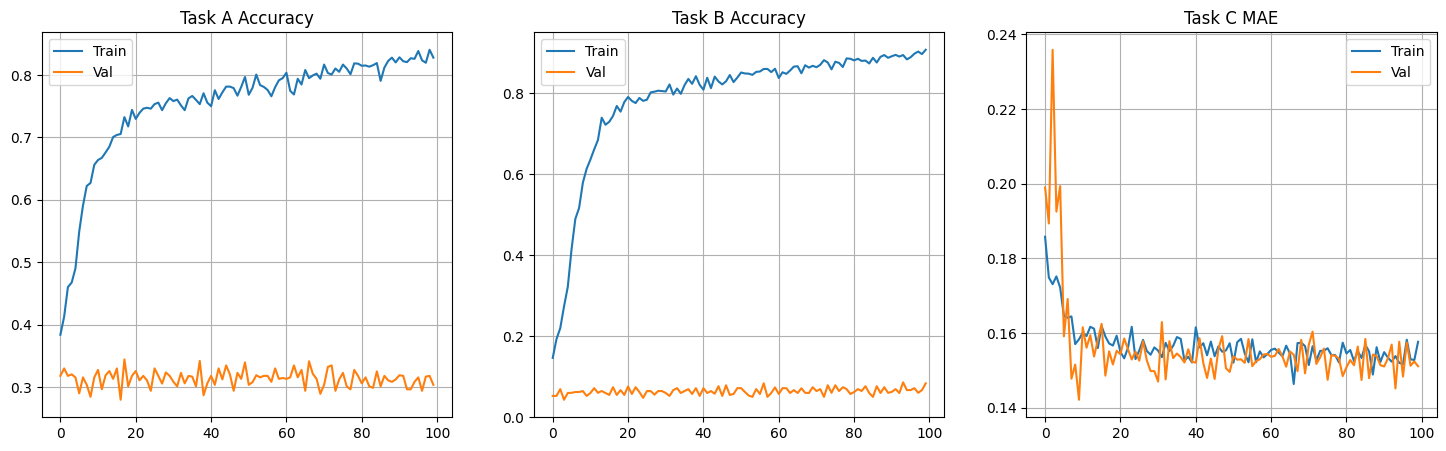

In [ ]:
plot_all_tasks(history_finetune.history)